# Nitrogen Management for Wastewater Treatment

## Stantec Water Institute

### Description: This app. does blah blah blah

- Contributors
  - Mark Bartlett
  - Sanaz Imen
  - Mehran Andalibd

#### Dash Install Reference for Jupyter (DO not delete)

In [1]:
# https://stackoverflow.com/questions/45490002/how-to-use-dash-within-jupyter-notebook-or-jupyterlab

# https://medium.com/plotly/introducing-jupyterdash-811f1f57c02e
# https://stackoverflow.com/questions/45490002/how-to-use-dash-within-jupyter-notebook-or-jupyterlab
# https://community.plotly.com/t/can-i-run-dash-app-in-jupyter/5235/3

# Running Dash online
# https://github.com/gwrun/tutorials/tree/main/plotly-dash/docker-compose
# https://www.datacamp.com/community/tutorials/learn-build-dash-python

# ssh for jupyter remote
# https://www.concurrency.com/blog/may-2019/key-based-authentication-for-openssh-on-windows
# https://superuser.com/questions/1433917/windows-10-ssh-client-password-less-access

#### Load Libraries

In [1]:
from jupyter_dash import JupyterDash

In [2]:
%load_ext autoreload
%autoreload 2
import warnings

import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
from IPython.display import IFrame
from sidecar import Sidecar

warnings.filterwarnings("ignore");

In [ ]:
# JupyterDash.infer_jupyter_proxy_config()

### Download some Data

In [3]:
df = pd.read_csv("https://plotly.github.io/datasets/country_indicators.csv")
available_indicators = df["Indicator Name"].unique()

In [3]:
pd.d

In [13]:
def test(a):
    print(a)

In [14]:
test(1)

1


## Dash Application Code

In [4]:
external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# Create server variable with Flask server object for use with gunicorn
server = app.server

app.layout = html.Div(
    [
        html.Div(
            [
                html.Div(
                    [
                        dcc.Dropdown(
                            id="crossfilter-xaxis-column",
                            options=[
                                {"label": i, "value": i} for i in available_indicators
                            ],
                            value="Fertility rate, total (births per woman)",
                        ),
                        dcc.RadioItems(
                            id="crossfilter-xaxis-type",
                            options=[
                                {"label": i, "value": i} for i in ["Linear", "Log"]
                            ],
                            value="Linear",
                            labelStyle={"display": "inline-block"},
                        ),
                    ],
                    style={"width": "49%", "display": "inline-block"},
                ),
                html.Div(
                    [
                        dcc.Dropdown(
                            id="crossfilter-yaxis-column",
                            options=[
                                {"label": i, "value": i} for i in available_indicators
                            ],
                            value="Life expectancy at birth, total (years)",
                        ),
                        dcc.RadioItems(
                            id="crossfilter-yaxis-type",
                            options=[
                                {"label": i, "value": i} for i in ["Linear", "Log"]
                            ],
                            value="Linear",
                            labelStyle={"display": "inline-block"},
                        ),
                    ],
                    style={"width": "49%", "float": "right", "display": "inline-block"},
                ),
            ],
            style={
                "borderBottom": "thin lightgrey solid",
                "backgroundColor": "rgb(250, 250, 250)",
                "padding": "10px 5px",
            },
        ),
        html.Div(
            [
                dcc.Graph(
                    id="crossfilter-indicator-scatter",
                    hoverData={"points": [{"customdata": "Japan"}]},
                )
            ],
            style={"width": "49%", "display": "inline-block", "padding": "0 20"},
        ),
        html.Div(
            [
                dcc.Graph(id="x-time-series"),
                dcc.Graph(id="y-time-series"),
            ],
            style={"display": "inline-block", "width": "49%"},
        ),
        html.Div(
            dcc.Slider(
                id="crossfilter-year--slider",
                min=df["Year"].min(),
                max=df["Year"].max(),
                value=df["Year"].max(),
                marks={str(year): str(year) for year in df["Year"].unique()},
                step=None,
            ),
            style={"width": "49%", "padding": "0px 20px 20px 20px"},
        ),
    ]
)


@app.callback(
    dash.dependencies.Output("crossfilter-indicator-scatter", "figure"),
    [
        dash.dependencies.Input("crossfilter-xaxis-column", "value"),
        dash.dependencies.Input("crossfilter-yaxis-column", "value"),
        dash.dependencies.Input("crossfilter-xaxis-type", "value"),
        dash.dependencies.Input("crossfilter-yaxis-type", "value"),
        dash.dependencies.Input("crossfilter-year--slider", "value"),
    ],
)
def update_graph(
    xaxis_column_name, yaxis_column_name, xaxis_type, yaxis_type, year_value
):
    dff = df[df["Year"] == year_value]

    return {
        "data": [
            dict(
                x=dff[dff["Indicator Name"] == xaxis_column_name]["Value"],
                y=dff[dff["Indicator Name"] == yaxis_column_name]["Value"],
                text=dff[dff["Indicator Name"] == yaxis_column_name]["Country Name"],
                customdata=dff[dff["Indicator Name"] == yaxis_column_name][
                    "Country Name"
                ],
                mode="markers",
                marker={
                    "size": 25,
                    "opacity": 0.7,
                    "color": "orange",
                    "line": {"width": 2, "color": "purple"},
                },
            )
        ],
        "layout": dict(
            xaxis={
                "title": xaxis_column_name,
                "type": "linear" if xaxis_type == "Linear" else "log",
            },
            yaxis={
                "title": yaxis_column_name,
                "type": "linear" if yaxis_type == "Linear" else "log",
            },
            margin={"l": 40, "b": 30, "t": 10, "r": 0},
            height=450,
            hovermode="closest",
        ),
    }


def create_time_series(dff, axis_type, title):
    return {
        "data": [dict(x=dff["Year"], y=dff["Value"], mode="lines+markers")],
        "layout": {
            "height": 225,
            "margin": {"l": 20, "b": 30, "r": 10, "t": 10},
            "annotations": [
                {
                    "x": 0,
                    "y": 0.85,
                    "xanchor": "left",
                    "yanchor": "bottom",
                    "xref": "paper",
                    "yref": "paper",
                    "showarrow": False,
                    "align": "left",
                    "bgcolor": "rgba(255, 255, 255, 0.5)",
                    "text": title,
                }
            ],
            "yaxis": {"type": "linear" if axis_type == "Linear" else "log"},
            "xaxis": {"showgrid": False},
        },
    }


@app.callback(
    dash.dependencies.Output("x-time-series", "figure"),
    [
        dash.dependencies.Input("crossfilter-indicator-scatter", "hoverData"),
        dash.dependencies.Input("crossfilter-xaxis-column", "value"),
        dash.dependencies.Input("crossfilter-xaxis-type", "value"),
    ],
)
def update_y_timeseries(hoverData, xaxis_column_name, axis_type):
    country_name = hoverData["points"][0]["customdata"]
    dff = df[df["Country Name"] == country_name]
    dff = dff[dff["Indicator Name"] == xaxis_column_name]
    title = "<b>{}</b><br>{}".format(country_name, xaxis_column_name)
    return create_time_series(dff, axis_type, title)


@app.callback(
    dash.dependencies.Output("y-time-series", "figure"),
    [
        dash.dependencies.Input("crossfilter-indicator-scatter", "hoverData"),
        dash.dependencies.Input("crossfilter-yaxis-column", "value"),
        dash.dependencies.Input("crossfilter-yaxis-type", "value"),
    ],
)
def update_x_timeseries(hoverData, yaxis_column_name, axis_type):
    dff = df[df["Country Name"] == hoverData["points"][0]["customdata"]]
    dff = dff[dff["Indicator Name"] == yaxis_column_name]
    return create_time_series(dff, axis_type, yaxis_column_name)

In [5]:
# Find the IP Addres of the Container
Container_IP = !awk 'END{print $1}' /etc/hosts
Container_IP

['172.22.0.3']

### Run the Dash Application for Development
- Change the host to '0.0.0.0' to broadcast outside of the network
- Otherwise set the host equatl to Container_IP[0] to develop within JupyterLab

In [6]:
app.run_server(
    host="0.0.0.0",
    debug=True,
    port=8050,
    dev_tools_ui=True,
    dev_tools_hot_reload=True,
    threaded=True,
)
# Go to Localhost:8050

Dash app running on http://0.0.0.0:8050/


In [ ]:
# '127.0.0.1'
# https://github.com/plotly/jupyter-dash/issues/43
# https://pythonspeed.com/articles/docker-connection-refused/

In [11]:
# https://github.com/plotly/jupyter-dash/issues/16

In [7]:
frame1 = IFrame(src="http://173.72.1.194:81", width="100%", height="500px")
sc = Sidecar(title="Dashboard")
with sc:
    display(frame1)

# Original Code from Mehran


In [7]:
import os
import pathlib as pl

import matplotlib.pyplot as plt
import pandas as pd
import pylab
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

root_dir = pl.Path(os.getcwd())

In [22]:
root_dir.parent / "data/processed"

PosixPath('/home/jovyan/work/data/processed')

In [14]:
process = input("what is your process (4stage or MLE):")

what is your process (4stage or MLE): MLE


In [23]:
dataframe1 = root_dir.parent / "data/processed" / "mle-med-ww-strength-20c.csv"
dataframe2 = root_dir.parent / "data/processed" / "4stage-med-ww-strength-20c.csv"

In [15]:
process = "mle"

In [24]:
for file in os.listdir(root_dir):
    if process in file:
        print(os.path.join("/mydir", file))
        print("You Are Evaluating a " + process + "  process")
        dataframe1 = file

In [25]:
for file in os.listdir(root_dir):
    if ".csv" in file:
        #        print(os.path.join("/mydir", file))
        #        print("You Are Evaluating a " + process + "  process")
        dataframe1 = file

In [36]:
df = pd.read_csv(dataframe1)
df

,X,Y,Z
0,5,6.250,10.360
1,5,6.375,10.200
2,5,6.500,9.760
3,5,6.625,9.540
4,5,6.750,9.240
...,...,...,...
776,15,14.500,4.653
777,15,14.625,4.618
778,15,14.750,4.584
779,15,14.875,4.540


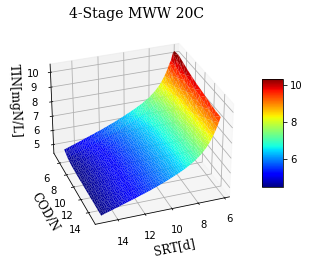

In [27]:
fig = plt.figure()
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(df["Y"], df["X"], df["Z"], cmap=plt.cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

font1 = {"family": "serif", "color": "black", "size": 14}
font2 = {"family": "serif", "color": "black", "size": 12}

ax.set_xlabel("SRT[d]", fontdict=font2)
ax.set_ylabel("COD/N", fontdict=font2)
ax.set_zlabel("TIN[mgN/L]", fontdict=font2)

# ax.set(xlim=(5,15), ylim=(5,15), zlim=(5,11))
if process == "MLE":
    plt.title("MLE MWW 20C", fontdict=font1)
else:
    plt.title("4-Stage MWW 20C", fontdict=font1)

# Set the angle of the camera and rotate
ax.view_init(30, 70)
plt.show()

In [52]:
len(df.X.unique())
len(df.Y.unique())
df.Z.shape
df.X.unique()

In [51]:
df.Y.unique()

array([ 6.25 ,  6.375,  6.5  ,  6.625,  6.75 ,  6.875,  7.   ,  7.125,
        7.25 ,  7.375,  7.5  ,  7.625,  7.75 ,  7.875,  8.   ,  8.125,
        8.25 ,  8.375,  8.5  ,  8.625,  8.75 ,  8.875,  9.   ,  9.125,
        9.25 ,  9.375,  9.5  ,  9.625,  9.75 ,  9.875, 10.   , 10.125,
       10.25 , 10.375, 10.5  , 10.625, 10.75 , 10.875, 11.   , 11.125,
       11.25 , 11.375, 11.5  , 11.625, 11.75 , 11.875, 12.   , 12.125,
       12.25 , 12.375, 12.5  , 12.625, 12.75 , 12.875, 13.   , 13.125,
       13.25 , 13.375, 13.5  , 13.625, 13.75 , 13.875, 14.   , 14.125,
       14.25 , 14.375, 14.5  , 14.625, 14.75 , 14.875, 15.   ])

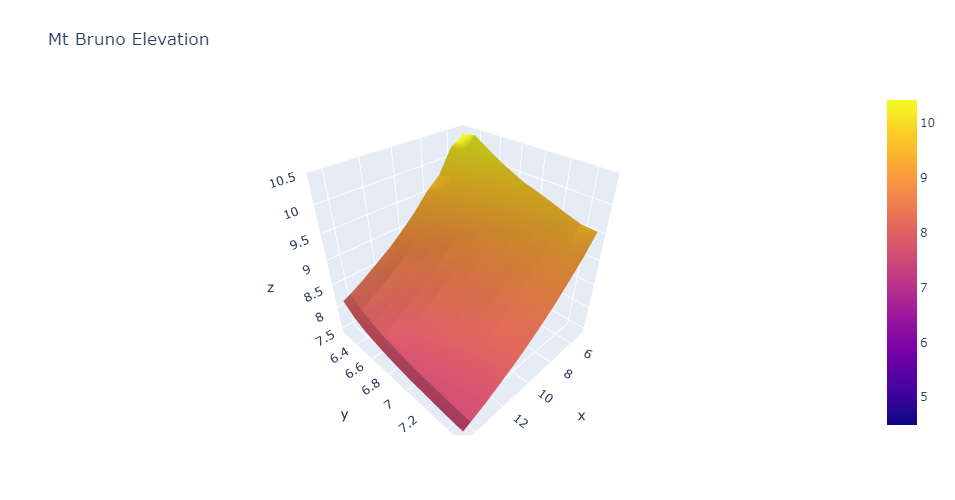

In [60]:
x = df.X.unique()
y = df.Y.unique()
z = df.Z.values.reshape(len(df.X.unique()), len(df.Y.unique()))

import pandas as pd
import plotly.graph_objects as go

# Read data from a csv
z_data = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv"
)

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

fig.update_layout(
    title="Mt Bruno Elevation",
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90),
)

fig.show()

In [33]:
import numpy as np

data = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv"
)
z = z_data.values
sh_0, sh_1 = z.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)

In [34]:
x, y

(array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
        0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
        0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
        0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
        0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ]),
 array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
        0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
        0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
        0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
        0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ]))